# libraries

In [ ]:
library(tidyverse)
library(GGally)
library(rstan)
library(ggmcmc)
library(tidybayes)

# generating dummy data

In [151]:
d <- tibble(
    x = abs(rnorm(2000, mean =1.5))
) %>%
    mutate(x = x / max(x)) %>%
    mutate(
        mu = -4 * x,
        sigma = exp(-0.5*x -0.5)
    ) %>%
    mutate( 
        y = as.numeric(map2(mu, sigma, function(m, s){rlnorm(1, meanlog = m, sdlog = s)}))
    )

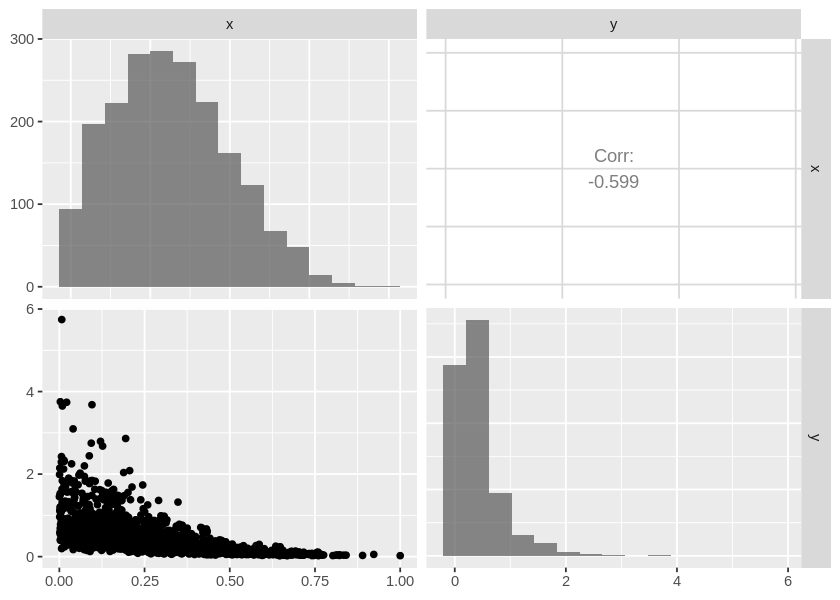

In [153]:
options(repr.plot.width=7, repr.plot.height=5)
d %>%
    select(x, y) %>%
    ggpairs(
        lower=list(combo="box"),
        upper=list(combo="blank"),
        diag=list(continuous=wrap("barDiag", position="identity", alpha=0.7, bins=15))
    )

# preprocessing

In [154]:
d.f <- d %>%
    filter(
        x < quantile(x, .98), 
        y < quantile(y, .98)
    )

In [155]:
d.f.max <- d.f %>%
    summarize_all(max) %>%
    select(x,y)

In [156]:
d.f <- d.f %>%
    mutate(
        x = x / d.f.max$x,
        y = y / d.f.max$y
    )

In [157]:
d.stan <- list(
    N = nrow(d.f),
    Y = d.f$y,
    X = d.f %>%
        select(x) %>%
        mutate(intercept = 1) %>%
        as.matrix(),
    D = 2
)

# MCMC with rstan

In [158]:
fit <- stan(file = './modeling.stan', data = d.stan, seed = 0,
            iter = 700, warmup = 200, chains = 3, pars=c('b', 'a'))


SAMPLING FOR MODEL 'modeling' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000399 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 3.99 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:   1 / 700 [  0%]  (Warmup)
Chain 1: Iteration:  70 / 700 [ 10%]  (Warmup)
Chain 1: Iteration: 140 / 700 [ 20%]  (Warmup)
Chain 1: Iteration: 201 / 700 [ 28%]  (Sampling)
Chain 1: Iteration: 270 / 700 [ 38%]  (Sampling)
Chain 1: Iteration: 340 / 700 [ 48%]  (Sampling)
Chain 1: Iteration: 410 / 700 [ 58%]  (Sampling)
Chain 1: Iteration: 480 / 700 [ 68%]  (Sampling)
Chain 1: Iteration: 550 / 700 [ 78%]  (Sampling)
Chain 1: Iteration: 620 / 700 [ 88%]  (Sampling)
Chain 1: Iteration: 690 / 700 [ 98%]  (Sampling)
Chain 1: Iteration: 700 / 700 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 1.04172 seconds (Warm-up)
Chain 1:                2.64395 seconds (Sampling)
Chain 1:                3.68567 seconds (To

# convergence diagnosis
## trace plot

In [ ]:
ggmcmc(ggs(fit, inc_warmup = T, stan_include_auxiliar = T), plot = "traceplot",
       file = "./trace.pdf")

## Rhat value

In [159]:
fit

Inference for Stan model: modeling.
3 chains, each with iter=700; warmup=200; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1500.

       mean se_mean   sd   2.5%    25%    50%    75%  97.5% n_eff Rhat
b[1]  -0.30    0.00 0.07  -0.43  -0.34  -0.30  -0.25  -0.15   930    1
b[2]  -0.53    0.00 0.03  -0.59  -0.55  -0.53  -0.50  -0.46   906    1
a[1]  -2.71    0.00 0.05  -2.81  -2.75  -2.71  -2.68  -2.61   592    1
a[2]  -0.65    0.00 0.03  -0.70  -0.66  -0.65  -0.63  -0.59   657    1
lp__ 298.37    0.06 1.40 294.74 297.71 298.69 299.39 300.09   619    1

Samples were drawn using NUTS(diag_e) at Thu Jun  6 18:01:56 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

# verifying if the parameters estimated above adequately fits to the true y

In [160]:
beta = c(-0.3, -0.53)
alpha = c(-2.71, -0.65)

y_pred could be generated, combining the independent variables and the parameters that were estimated above.

In [161]:
d.f.pred <- d.f %>%
    mutate(
        sigma = exp(x * beta[1] + beta[2]),
        mu = x*alpha[1] + alpha[2]
    ) %>%
    mutate(
        y_pred = rlnorm(n(), meanlog = mu, sdlog = sigma)
    ) %>%
    filter(y_pred < quantile(y_pred, .98))

If each mu is assigned to some discrete ranks, y and y_pred can be plotted as discrete histograms which shows how similar the two distributions are within the same rank.

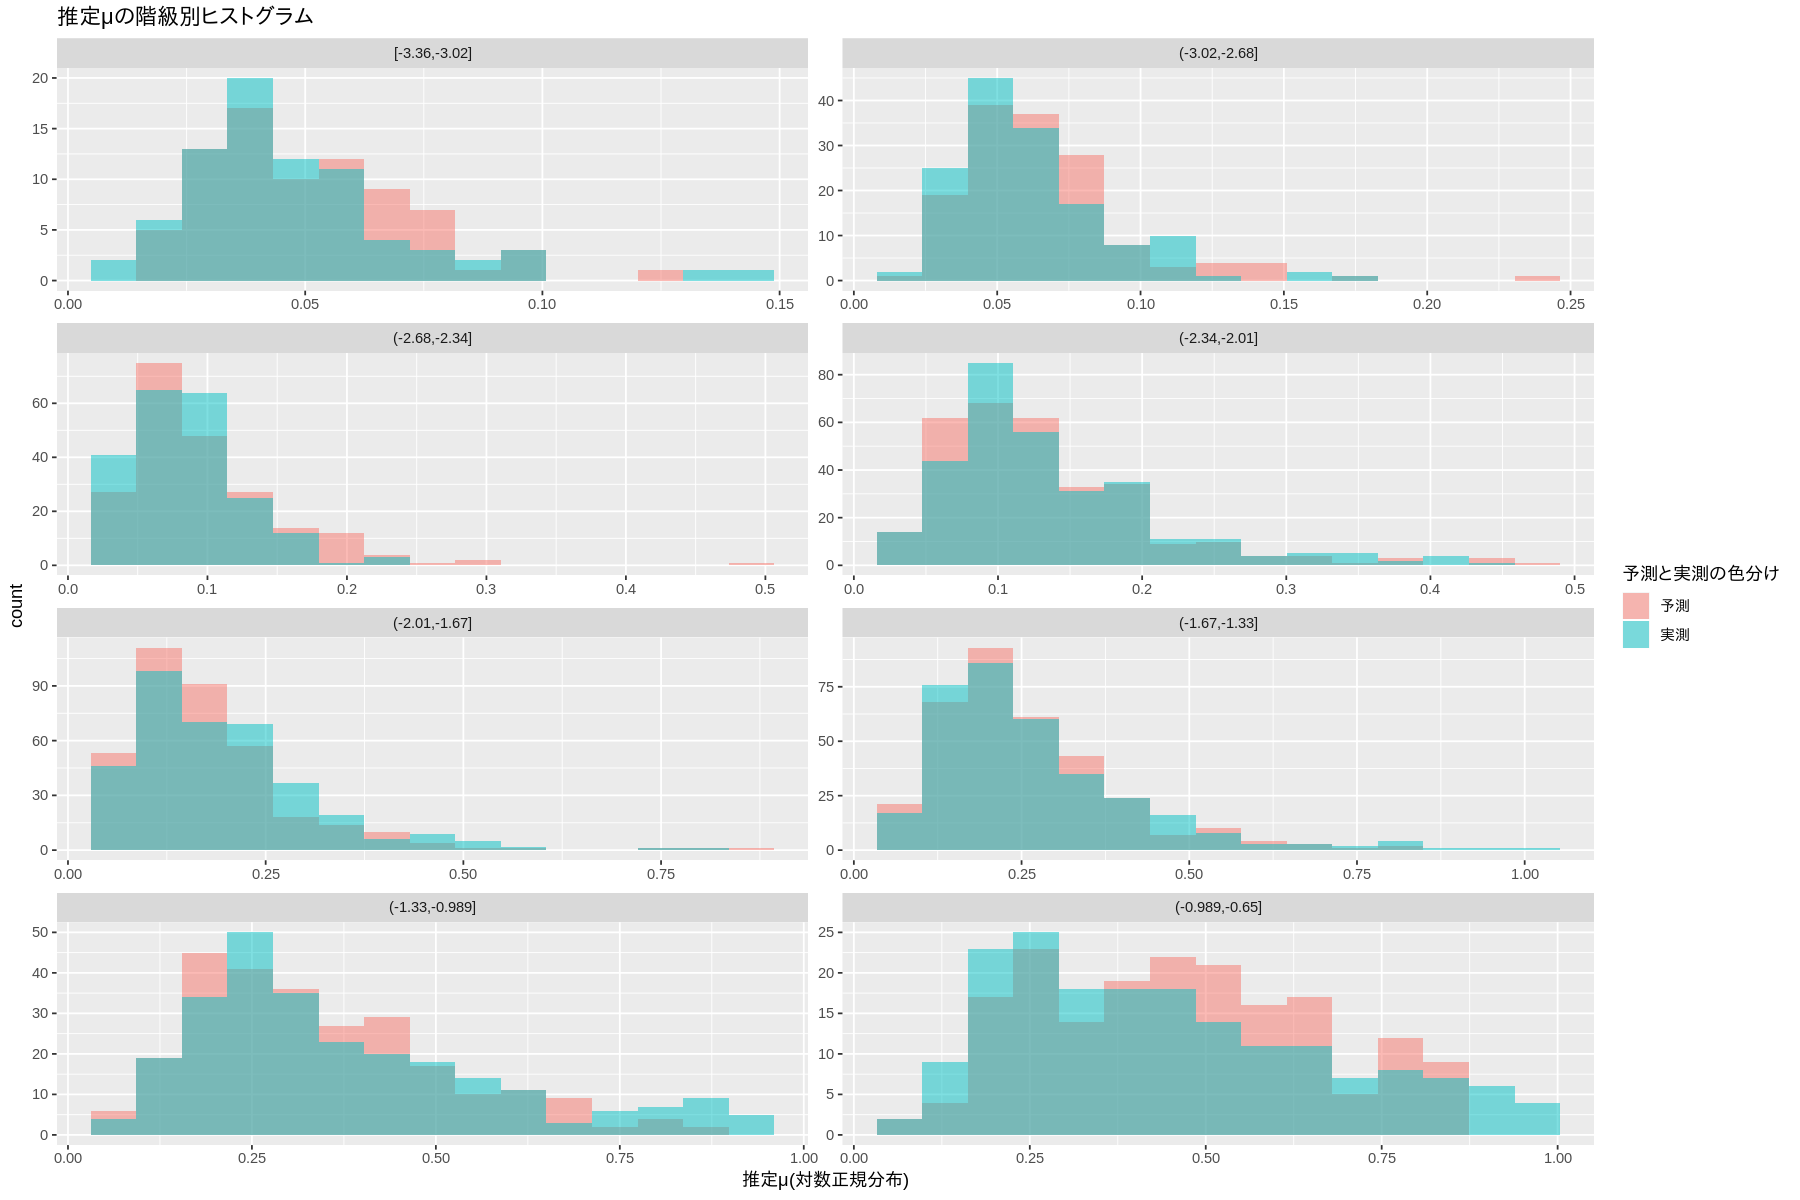

In [163]:
options(repr.plot.width=15, repr.plot.height=10)
d.f.pred %>%
    mutate(class = cut_interval(mu, n = 8)) %>%
    select(y, y_pred, class) %>%
    gather("name", "value", y, y_pred) %>% 
    arrange(class) %>%
    mutate(name = if_else(name == "y", "実測", "予測")) %>%
    ggplot(
        aes(value, fill = name)
    ) +
    geom_histogram(bins = 15, position = "identity", alpha = 0.5) +
    facet_wrap(~class, ncol = 2, scales="free") +
    labs(
        x = "推定μ(対数正規分布)",
        fill = "予測と実測の色分け",
        title="推定μの階級別ヒストグラム"
    )